In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from collections import defaultdict
from scipy.stats import randint
import matplotlib.pyplot as plt
from rfpimp import permutation_importances
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import glob


In [26]:
#Put datasets together because it is irritating to feature engineer on separate train and test.
files = ['../mcats/data/train_data.csv', '../mcats/data/test_data.csv', '../mcats/data/val_data.csv']
data =  pd.DataFrame()
for file in files:
    # read and append the file
    data= pd.concat([data, pd.read_csv(file)], axis=0)
data = data.reset_index(drop=True)
print (data)

                                                   Song     tempo  beats_mean  \
0         KMR BND - SkeletBeatz - Twenty Eight Days.mp3  1.023760    0.041805   
1                                  chapardos - vrai.mp3 -1.093593    0.131433   
2     Beat scientists - Zaroc Beats - Mi serpiente y... -1.093593   -0.891415   
3                               KMR BND - AO - Lamp.mp3 -2.567072   -0.179055   
4                     Kidd Young - Legendary Ft Zio.mp3 -0.613660    0.128563   
...                                                 ...       ...         ...   
5864         Puppasonic - Travailler pourquoi faire.mp3  1.355626    0.343757   
5865  DON VALDES - Let reggae music free (Free Music...  1.036462    0.248178   
5866  Ewerity - Ewerity - The Lions Cycle - 01 Eweri...  0.752761    0.373150   
5867  Yuanan &quot;J.A.R&quot; - Sunrise Riddim  Pro...  0.752761    0.319379   
5868                   Viento y Tïerra - DE LOS DOS.mp3  2.130737    0.072966   

      beats_var  zero_cross

Remember to split the data so training the model doesn't take so long. When the model looks good, use the whole dataset.

Random forest is being used to prevent overcorrelation. The previous result should not affect the next results. So, it should give a more accurate prediction.

In [22]:
# Load the data splits
train_data = pd.read_csv('../mcats/data/train_data.csv')
val_data = pd.read_csv('../mcats/data/test_data.csv')
test_data = pd.read_csv('../mcats/data/val_data.csv')

# Split the data into X and y
X_train = train_data.iloc[:, 1:-1]
y_train = train_data.iloc[:, -1]
X_val = val_data.iloc[:, 1:-1]
y_val = val_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]

In [12]:
X_train.head(3)

,tempo,beats_mean,beats_var,zero_crossings_mean,zero_crossings_var,spectral_centroids_mean,spectral_centroids_var,spectral_rolloff_mean,spectral_rolloff_var,mfcc_1_mean,...,mfcc_36_mean,mfcc_36_var,mfcc_37_mean,mfcc_37_var,mfcc_38_mean,mfcc_38_var,mfcc_39_mean,mfcc_39_var,mfcc_40_mean,mfcc_40_var
0,1.023760,0.041805,0.369683,-1.667139,-1.857651,-1.014139,1.617622,-0.748374,3.350232,-1.439589,...,0.872739,-0.699038,0.211035,-0.785231,-1.540956,-0.814879,-0.169494,-0.498867,-0.134263,-0.642835
1,-1.093593,0.131433,0.158320,0.245864,0.307460,0.027929,4.313408,-0.164304,4.167452,-1.413251,...,-3.029440,0.205955,-1.972509,-0.701640,-0.696683,-0.315596,0.637620,-0.674785,-0.006971,-0.289456
2,-1.093593,-0.891415,-1.272266,1.897239,1.885262,1.230415,2.093804,0.791755,1.706036,0.336232,...,-1.799229,-0.692739,-2.398123,-0.617969,-2.066134,-0.177092,-2.151214,-0.192205,-0.765171,-0.329696


In [23]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X_train, y_train)

NameError: name 'SelectFromModel' is not defined

In [63]:
result_test = permutation_importance(
    rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_train.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X_train.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(90,90))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

[0.01094825 0.00469533 0.00507812 0.01281818 0.01409795 0.01490027
 0.02224258 0.01884579 0.02322582 0.02144019 0.00997711 0.01345558
 0.01218793 0.01954553 0.01234199 0.01503313 0.01253663 0.01001634
 0.01535034 0.01763853 0.01227927 0.01158851 0.01449268 0.01671355
 0.01122323 0.01028144 0.00935534 0.01265636 0.00895858 0.00976712
 0.01118307 0.01528239 0.00905366 0.01062218 0.01118288 0.01105858
 0.00847125 0.01204891 0.00783626 0.01038956 0.00771964 0.01179929
 0.00824107 0.01066961 0.00852172 0.00952929 0.00884159 0.01066026
 0.00926873 0.01402754 0.01026059 0.00945406 0.00795583 0.00960013
 0.00856503 0.00835046 0.00834424 0.01017556 0.00881197 0.0086827
 0.01133765 0.00915671 0.01079947 0.00827501 0.01230184 0.00882356
 0.01207851 0.00781463 0.01205354 0.00991373 0.0121595  0.00788708
 0.01159479 0.00847768 0.01240986 0.00851189 0.01033048 0.00926847
 0.01303837 0.00857964 0.00927303 0.00922593 0.01302589 0.00882626
 0.01101863 0.00857831 0.01294593 0.00869662 0.01329727]


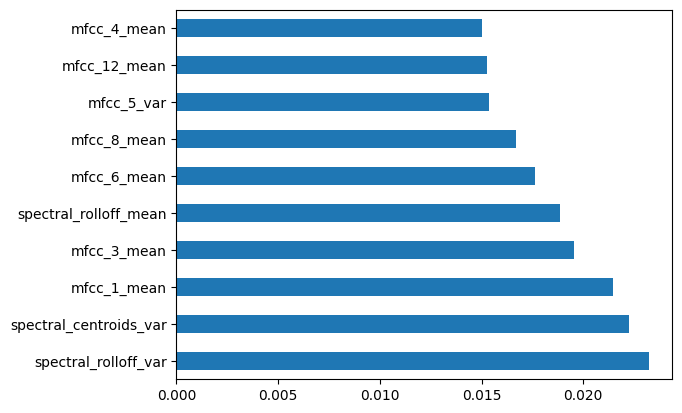

In [14]:
#Looks at the top 10 features that have the most impact
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [18]:
from rfpimp import dropcol_importances

rf = RandomForestClassifier(warm_start=True)
def dropcol_importances(rf, X_train, y_train):
    rf.random_state = 42
    rf.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf.random_state = 42
        rf.fit(X_train, y_train)
        o = rf.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


imp = dropcol_importances(rf, X_train, y_train)
imp.plot(kind = 'barh')

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

In [182]:
clf = RandomForestClassifier(n_estimators=49, random_state=42, max_depth =3)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.50


In [183]:
clf = RandomForestClassifier(n_estimators=49, random_state=42, max_depth =3)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_train, y_train)))

Accuracy on test data: 0.55


In [185]:
#Using the recommended best paramters to create a new model
model_n = RandomForestClassifier(n_estimators=49, random_state=42, max_depth =3)  
model_n.fit(X_train, y_train)
preds = model_n.predict(X_train)
y_true = y_train
y_pred = preds
target_names = ['hiphop','classical','pop','electronic','metal', 'rock','country','reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       0.54      0.40      0.46       477
   classical       0.73      0.94      0.82       437
         pop       0.41      0.25      0.31       423
  electronic       0.56      0.56      0.56       424
       metal       0.61      0.85      0.71       443
        rock       0.46      0.24      0.32       450
     country       0.46      0.34      0.39       419
      reggae       0.47      0.79      0.59       457

    accuracy                           0.55      3530
   macro avg       0.53      0.55      0.52      3530
weighted avg       0.53      0.55      0.52      3530



In [186]:
#Using the recommended best paramters to create a new model
model_n = RandomForestClassifier(n_estimators=49, random_state=42, max_depth =3)  
model_n.fit(X_train, y_train)
preds = model_n.predict(X_test)
y_true = y_test
y_pred = preds
target_names = ['hiphop','classical','pop','electronic','metal', 'rock','country','reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       0.39      0.39      0.39       140
   classical       0.79      0.92      0.85       172
         pop       0.43      0.26      0.32       164
  electronic       0.47      0.38      0.42       148
       metal       0.56      0.87      0.68       122
        rock       0.39      0.16      0.23       154
     country       0.34      0.32      0.33       119
      reggae       0.41      0.66      0.51       155

    accuracy                           0.50      1174
   macro avg       0.47      0.50      0.47      1174
weighted avg       0.48      0.50      0.47      1174



In [189]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(n_estimators=49, random_state=42, max_depth =3)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=49, random_state=42)

AttributeError: 'Series' object has no attribute 'feature_names'

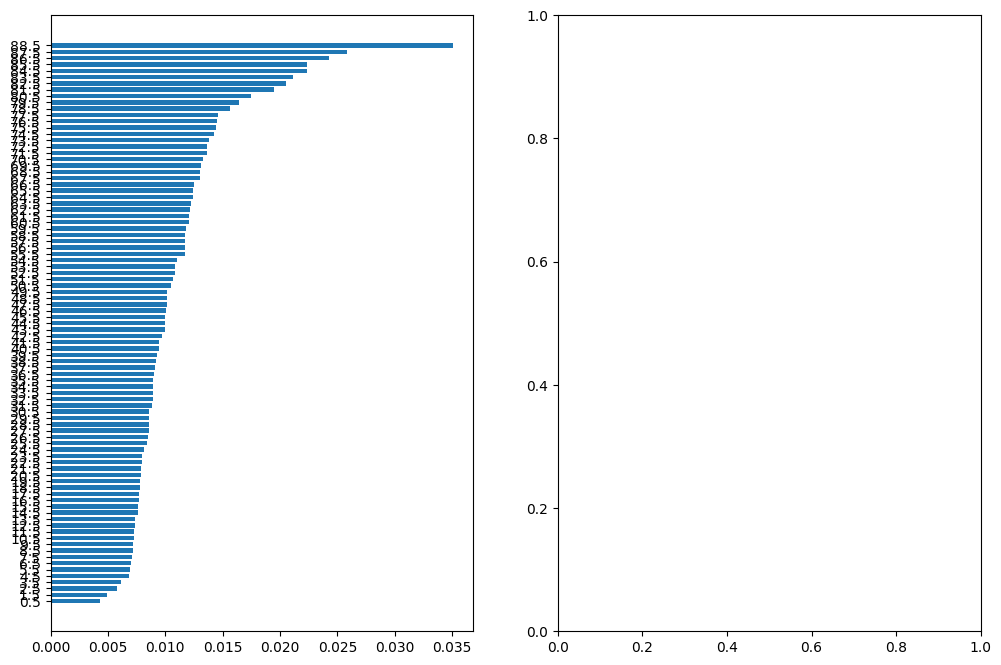

In [28]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data["genre"].feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'feature_names'

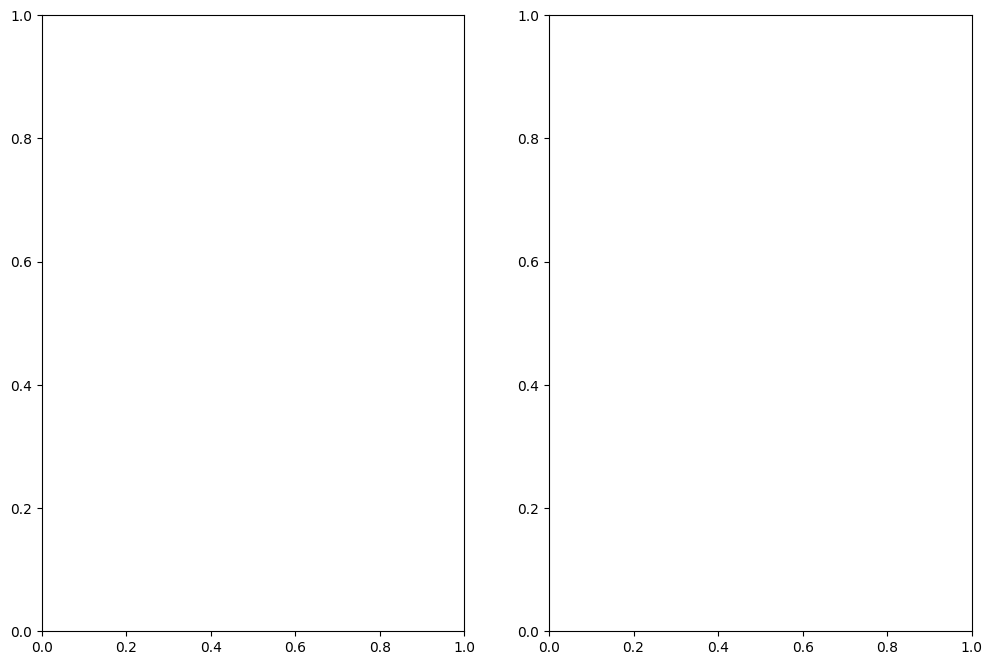

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [55]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

InvalidIndexError: (slice(None, None, None), [0, 3, 6, 13, 15, 24, 27, 29, 42, 49, 53, 67, 69])

In [4]:
#The parenthesis are blank here because it will run the defaul values
model = RandomForestClassifier()  
model.fit(X_train, y_train)
preds = model.predict(X_train)
#y_ true is y_test  predict on x_text  y_pred is the output of the model
y_true = y_train
y_pred = preds
target_names = ['hiphop','classical','pop','electronic','metal', 'rock','country','reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00       477
   classical       1.00      1.00      1.00       437
         pop       1.00      1.00      1.00       423
  electronic       1.00      1.00      1.00       424
       metal       1.00      1.00      1.00       443
        rock       1.00      1.00      1.00       450
     country       1.00      1.00      1.00       419
      reggae       1.00      1.00      1.00       457

    accuracy                           1.00      3530
   macro avg       1.00      1.00      1.00      3530
weighted avg       1.00      1.00      1.00      3530



In [5]:
param_grid = {
  
    'n_estimators': [2, 30, 50, 100, 200, 300, 500, 1000]
}
random_forest_model = RandomForestClassifier()
# Looking for best parameters for the random forest model
grid_search = GridSearchCV(estimator = random_forest_model , param_grid = param_grid, cv = 5, n_jobs = -1)

In [6]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [2, 30, 50, 100, 200, 300, 500, 1000]})

In [14]:
grid_search.best_score_

0.3930028272338671

In [15]:
grid_search.best_params_

{'n_estimators': 1000}

In [16]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=1000)

# Only adjusting n_estimators does not help the model from overfitting

In [20]:
model_13 = RandomForestClassifier(n_estimators=350)  
model_13.fit(X_train, y_train)
preds_13 = model_13.predict(X_train)
y_true = y_train
y_pred = preds_13
target_names = ['hiphop','classical','pop','electronic','metal', 'rock','country','reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00       477
   classical       1.00      1.00      1.00       437
         pop       1.00      1.00      1.00       423
  electronic       1.00      1.00      1.00       424
       metal       1.00      1.00      1.00       443
        rock       1.00      1.00      1.00       450
     country       1.00      1.00      1.00       419
      reggae       1.00      1.00      1.00       457

    accuracy                           1.00      3530
   macro avg       1.00      1.00      1.00      3530
weighted avg       1.00      1.00      1.00      3530



# According to the literature n_estimators, max_features, max_depth, and min_samples_split. Have the biggest impact on hyperparamteres. There are two ways to do a random search for the max_features. Either use auto, sqrt, log  or use random intergers.

In [4]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'max_features': ['auto', 'sqrt', 'log2', None],
                    'max_depth' : randint(1,32),
                    'min_samples_split':randint(2, 100), 
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=6, max_features=None, min_samples_split=14, n_estimators=73; total time=   2.6s
[CV] END max_depth=6, max_features=None, min_samples_split=14, n_estimators=73; total time=   1.3s
[CV] END max_depth=6, max_features=None, min_samples_split=14, n_estimators=73; total time=   1.4s
[CV] END max_depth=6, max_features=None, min_samples_split=14, n_estimators=73; total time=   1.9s
[CV] END max_depth=6, max_features=None, min_samples_split=14, n_estimators=73; total time=   1.9s
[CV] END max_depth=10, max_features=None, min_samples_split=7, n_estimators=848; total time=  36.7s
[CV] END max_depth=10, max_features=None, min_samples_split=7, n_estimators=848; total time=  38.3s
[CV] END max_depth=10, max_features=None, min_samples_split=7, n_estimators=848; total time=  42.6s
[CV] END max_depth=10, max_features=None, min_samples_split=7, n_estimators=848; total time=  47.4s
[CV] END max_depth=10, max_features=None, 

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=3, n_estimators=973; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=3, n_estimators=973; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=3, n_estimators=973; total time=   2.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=3, n_estimators=973; total time=   2.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=3, n_estimators=973; total time=   2.2s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=8, n_estimators=282; total time=   1.4s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=8, n_estimators=282; total time=   1.4s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=8, n_estimators=282; total time=   1.4s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=8, n_estimators=282; total time=   1.8s
[CV] END max_depth=8, max_features=sqrt, min_samples_split=8, n_estimators=282; total time=   1.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=19, max_features=auto, min_samples_split=20, n_estimators=469; total time=   3.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=19, max_features=auto, min_samples_split=20, n_estimators=469; total time=   3.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=19, max_features=auto, min_samples_split=20, n_estimators=469; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=19, max_features=auto, min_samples_split=20, n_estimators=469; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=19, max_features=auto, min_samples_split=20, n_estimators=469; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=30, n_estimators=926; total time=   5.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=30, n_estimators=926; total time=   5.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=30, n_estimators=926; total time=   5.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=30, n_estimators=926; total time=   5.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=30, n_estimators=926; total time=   5.6s
[CV] END max_depth=15, max_features=log2, min_samples_split=70, n_estimators=216; total time=   1.0s
[CV] END max_depth=15, max_features=log2, min_samples_split=70, n_estimators=216; total time=   1.0s
[CV] END max_depth=15, max_features=log2, min_samples_split=70, n_estimators=216; total time=   1.0s
[CV] END max_depth=15, max_features=log2, min_samples_split=70, n_estimators=216; total time=   1.0s
[CV] END max_depth=15, max_features=log2, min_samples_split=70, n_estimators=216; total time=   1.1s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=96, n_estimators=865; total time=   4.9s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=96, n_estimators=865; total time=   4.7s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=96, n_estimators=865; total time=   4.8s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=96, n_estimators=865; total tim

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=83, n_estimators=265; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=83, n_estimators=265; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=83, n_estimators=265; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=83, n_estimators=265; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=83, n_estimators=265; total time=   0.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_split=49, n_estimators=634; total time=   3.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_split=49, n_estimators=634; total time=   3.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_split=49, n_estimators=634; total time=   4.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_split=49, n_estimators=634; total time=   3.9s
[CV] END max_depth=25, max_features=sqrt, min_samples_split=49, n_estimators=634; total time=   3.8s
[CV] END max_depth=9, max_features=log2, min_samples_split=73, n_estimators=388; total time=   1.6s
[CV] END max_depth=9, max_features=log2, min_samples_split=73, n_estimators=388; total time=   1.6s
[CV] END max_depth=9, max_features=log2, min_samples_split=73, n_estimators=388; total time=   1.7s
[CV] END max_depth=9, max_features=log2, min_samples_split=73, n_estimators=388; total time=   

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=4, max_features=auto, min_samples_split=26, n_estimators=498; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=4, max_features=auto, min_samples_split=26, n_estimators=498; total time=   2.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=4, max_features=auto, min_samples_split=26, n_estimators=498; total time=   2.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=4, max_features=auto, min_samples_split=26, n_estimators=498; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=4, max_features=auto, min_samples_split=26, n_estimators=498; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=28, n_estimators=821; total time=   4.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=28, n_estimators=821; total time=   4.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=28, n_estimators=821; total time=   4.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=28, n_estimators=821; total time=   4.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=12, max_features=auto, min_samples_split=28, n_estimators=821; total time=   5.0s
[CV] END max_depth=17, max_features=sqrt, min_samples_split=43, n_estimators=467; total time=   2.4s
[CV] END max_depth=17, max_features=sqrt, min_samples_split=43, n_estimators=467; total time=   2.6s
[CV] END max_depth=17, max_features=sqrt, min_samples_split=43, n_estimators=467; total time=   3.1s
[CV] END max_depth=17, max_features=sqrt, min_samples_split=43, n_estimators=467; total time=   3.2s
[CV] END max_depth=17, max_features=sqrt, min_samples_split=43, n_estimators=467; total time=   2.4s
[CV] END max_depth=16, max_features=auto, min_samples_split=70, n_estimators=26; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=16, max_features=auto, min_samples_split=70, n_estimators=26; total time=   0.2s
[CV] END max_depth=16, max_features=auto, min_samples_split=70, n_estimators=26; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=16, max_features=auto, min_samples_split=70, n_estimators=26; total time=   0.2s
[CV] END max_depth=16, max_features=auto, min_samples_split=70, n_estimators=26; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=16, max_features=log2, min_samples_split=89, n_estimators=904; total time=   3.1s
[CV] END max_depth=16, max_features=log2, min_samples_split=89, n_estimators=904; total time=   3.1s
[CV] END max_depth=16, max_features=log2, min_samples_split=89, n_estimators=904; total time=   3.1s
[CV] END max_depth=16, max_features=log2, min_samples_split=89, n_estimators=904; total time=   3.0s
[CV] END max_depth=16, max_features=log2, min_samples_split=89, n_estimators=904; total time=   3.1s
[CV] END max_depth=27, max_features=sqrt, min_samples_split=24, n_estimators=778; total time=   4.1s
[CV] END max_depth=27, max_features=sqrt, min_samples_split=24, n_estimators=778; total time=   4.2s
[CV] END max_depth=27, max_features=sqrt, min_samples_split=24, n_estimators=778; total time=   4.2s
[CV] END max_depth=27, max_features=sqrt, min_samples_split=24, n_estimators=778; total time=   4.2s
[CV] END max_depth=27, max_features=sqrt, min_samples_split=24, n_estimators=778; total tim

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_split=76, n_estimators=191; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_split=76, n_estimators=191; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_split=76, n_estimators=191; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_split=76, n_estimators=191; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_split=76, n_estimators=191; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.8s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=79, n_estimators=772; total time=   3.5s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=79, n_estimators=772; total time=   3.6s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=79, n_estimators=772; total time=   3.6s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=79, n_estimators=772; total time=   3.4s
[CV] END max_depth=24, max_features=sqrt, min_samples_split=79, n_estimators=772; total time=   3.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=79, n_estimators=775; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=79, n_estimators=775; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=79, n_estimators=775; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=79, n_estimators=775; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=1, max_features=auto, min_samples_split=79, n_estimators=775; total time=   1.6s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=72, n_estimators=515; total time=   2.3s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=72, n_estimators=515; total time=   2.3s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=72, n_estimators=515; total time=   2.2s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=72, n_estimators=515; total time=   2.3s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=72, n_estimators=515; total time=   2.3s
[CV] END max_depth=13, max_features=None, min_samples_split=23, n_estimators=716; total time=  26.7s
[CV] END max_depth=13, max_features=None, min_samples_split=23, n_estimators=716; total time=  30.4s
[CV] END max_depth=13, max_features=None, min_samples_split=23, n_estimators=716; total time=  33.6s
[CV] END max_depth=13, max_features=None, min_samples_split=23, n_estimators=716; total time

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=34, n_estimators=141; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=34, n_estimators=141; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=34, n_estimators=141; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=34, n_estimators=141; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=34, n_estimators=141; total time=   1.0s
[CV] END max_depth=2, max_features=log2, min_samples_split=62, n_estimators=490; total time=   1.4s
[CV] END max_depth=2, max_features=log2, min_samples_split=62, n_estimators=490; total time=   1.4s
[CV] END max_depth=2, max_features=log2, min_samples_split=62, n_estimators=490; total time=   1.4s
[CV] END max_depth=2, max_features=log2, min_samples_split=62, n_estimators=490; total time=   1.4s
[CV] END max_depth=2, max_features=log2, min_samples_split=62, n_estimators=490; total time=   1.4s
[CV] END max_depth=25, max_features=log2, min_samples_split=99, n_estimators=131; total time=   0.5s
[CV] END max_depth=25, max_features=log2, min_samples_split=99, n_estimators=131; total time=   0.6s
[CV] END max_depth=25, max_features=log2, min_samples_split=99, n_estimators=131; total time=   0.6s
[CV] END max_depth=25, max_features=log2, min_samples_split=99, n_estimators=131; total time=   

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=12, n_estimators=695; total time=   4.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=12, n_estimators=695; total time=   4.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=12, n_estimators=695; total time=   5.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=12, n_estimators=695; total time=   4.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=12, n_estimators=695; total time=   4.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=84, n_estimators=471; total time=   1.2s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=84, n_estimators=471; total time=   1.2s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=84, n_estimators=471; total time=   1.2s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=84, n_estimators=471; total time=   1.2s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=84, n_estimators=471; total time=   1.2s
[CV] END max_depth=7, max_features=log2, min_samples_split=73, n_estimators=177; total time=   0.6s
[CV] END max_depth=7, max_features=log2, min_samples_split=73, n_estimators=177; total time=   0.7s
[CV] END max_depth=7, max_features=log2, min_samples_split=73, n_estimators=177; total time=   0.7s
[CV] END max_depth=7, max_features=log2, min_samples_split=73, n_estimators=177; total time=   0.6s

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=50, n_estimators=279; total time=   3.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=50, n_estimators=279; total time=   4.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=50, n_estimators=279; total time=   3.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=50, n_estimators=279; total time=   4.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=50, n_estimators=279; total time=   3.9s
[CV] END max_depth=6, max_features=sqrt, min_samples_split=99, n_estimators=694; total time=   8.4s
[CV] END max_depth=6, max_features=sqrt, min_samples_split=99, n_estimators=694; total time=   8.0s
[CV] END max_depth=6, max_features=sqrt, min_samples_split=99, n_estimators=694; total time=   8.6s
[CV] END max_depth=6, max_features=sqrt, min_samples_split=99, n_estimators=694; total time=   7.5s
[CV] END max_depth=6, max_features=sqrt, min_samples_split=99, n_estimators=694; total time=   7.4s
[CV] END max_depth=21, max_features=log2, min_samples_split=98, n_estimators=184; total time=   2.1s
[CV] END max_depth=21, max_features=log2, min_samples_split=98, n_estimators=184; total time=   2.2s
[CV] END max_depth=21, max_features=log2, min_samples_split=98, n_estimators=184; total time=   2.2s
[CV] END max_depth=21, max_features=log2, min_samples_split=98, n_estimators=184; total time=   

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_split=91, n_estimators=406; total time=   5.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_split=91, n_estimators=406; total time=   5.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_split=91, n_estimators=406; total time=   5.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_split=91, n_estimators=406; total time=   5.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_split=91, n_estimators=406; total time=   5.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=85, n_estimators=26; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=85, n_estimators=26; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=85, n_estimators=26; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=85, n_estimators=26; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=85, n_estimators=26; total time=   1.0s
[CV] END max_depth=18, max_features=log2, min_samples_split=15, n_estimators=213; total time=   4.0s
[CV] END max_depth=18, max_features=log2, min_samples_split=15, n_estimators=213; total time=   3.5s
[CV] END max_depth=18, max_features=log2, min_samples_split=15, n_estimators=213; total time=   3.0s
[CV] END max_depth=18, max_features=log2, min_samples_split=15, n_estimators=213; total time=   3.5s
[CV] END max_depth=18, max_features=log2, min_samples_split=15, n_estimators=213; total time=   3.8s
[CV] END max_depth=21, max_features=None, min_samples_split=8, n_estimators=718; total time= 1.3min
[CV] END max_depth=21, max_features=None, min_samples_split=8, n_estimators=718; total time= 1.2min
[CV] END max_depth=21, max_features=None, min_samples_split=8, n_estimators=718; total time= 1.4min
[CV] END max_depth=21, max_features=None, min_samples_split=8, n_estimators=718; total time= 1.2

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=47, n_estimators=452; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=47, n_estimators=452; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=47, n_estimators=452; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=47, n_estimators=452; total time=   3.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=47, n_estimators=452; total time=   2.6s
[CV] END max_depth=21, max_features=log2, min_samples_split=80, n_estimators=303; total time=   1.6s
[CV] END max_depth=21, max_features=log2, min_samples_split=80, n_estimators=303; total time=   1.5s
[CV] END max_depth=21, max_features=log2, min_samples_split=80, n_estimators=303; total time=   1.5s
[CV] END max_depth=21, max_features=log2, min_samples_split=80, n_estimators=303; total time=   1.3s
[CV] END max_depth=21, max_features=log2, min_samples_split=80, n_estimators=303; total time=   1.4s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=65, n_estimators=844; total time=   2.1s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=65, n_estimators=844; total time=   2.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=65, n_estimators=844; total time=   2.0s
[CV] END max_depth=1, max_features=sqrt, min_samples_split=65, n_estimators=844; total time=  

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=3, max_features=auto, min_samples_split=85, n_estimators=49; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=3, max_features=auto, min_samples_split=85, n_estimators=49; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=3, max_features=auto, min_samples_split=85, n_estimators=49; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=3, max_features=auto, min_samples_split=85, n_estimators=49; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=3, max_features=auto, min_samples_split=85, n_estimators=49; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.4s
[CV] END max_depth=19, max_features=None, min_samples_split=30, n_estimators=223; total time=   9.8s
[CV] END max_depth=19, max_features=None, min_samples_split=30, n_estimators=223; total time=  10.3s
[CV] END max_depth=19, max_features=None, min_samples_split=30, n_estimators=223; total time=   9.2s
[CV] END max_depth=19, max_features=None, min_samples_split=30, n_estimators=223; total time=   9.4s
[CV] END max_depth=19, max_features=None, min_samples_split=30, n_estimators=223; total time=   9.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=34, n_estimators=521; total time=   2.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=34, n_estimators=521; total time=   2.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=34, n_estimators=521; total time=   2.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=34, n_estimators=521; total time=   2.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=11, max_features=auto, min_samples_split=34, n_estimators=521; total time=   2.9s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=52, n_estimators=592; total time=   3.0s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=52, n_estimators=592; total time=   3.0s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=52, n_estimators=592; total time=   3.3s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=52, n_estimators=592; total time=   3.2s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=52, n_estimators=592; total time=   3.2s
[CV] END max_depth=10, max_features=auto, min_samples_split=85, n_estimators=25; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=85, n_estimators=25; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_split=85, n_estimators=25; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=85, n_estimators=25; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_split=85, n_estimators=25; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=18, max_features=log2, min_samples_split=22, n_estimators=45; total time=   0.3s
[CV] END max_depth=18, max_features=log2, min_samples_split=22, n_estimators=45; total time=   0.3s
[CV] END max_depth=18, max_features=log2, min_samples_split=22, n_estimators=45; total time=   0.3s
[CV] END max_depth=18, max_features=log2, min_samples_split=22, n_estimators=45; total time=   0.3s
[CV] END max_depth=18, max_features=log2, min_samples_split=22, n_estimators=45; total time=   0.3s
[CV] END max_depth=16, max_features=log2, min_samples_split=93, n_estimators=911; total time=   3.5s
[CV] END max_depth=16, max_features=log2, min_samples_split=93, n_estimators=911; total time=   3.6s
[CV] END max_depth=16, max_features=log2, min_samples_split=93, n_estimators=911; total time=   3.8s
[CV] END max_depth=16, max_features=log2, min_samples_split=93, n_estimators=911; total time=   4.1s
[CV] END max_depth=16, max_features=log2, min_samples_split=93, n_estimators=911; total time=   

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=36, n_estimators=101; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=36, n_estimators=101; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=36, n_estimators=101; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=36, n_estimators=101; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_split=36, n_estimators=101; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_split=21, n_estimators=452; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_split=21, n_estimators=452; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_split=21, n_estimators=452; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_split=21, n_estimators=452; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_split=21, n_estimators=452; total time=   1.9s
[CV] END max_depth=25, max_features=None, min_samples_split=96, n_estimators=167; total time=   5.9s
[CV] END max_depth=25, max_features=None, min_samples_split=96, n_estimators=167; total time=   6.3s
[CV] END max_depth=25, max_features=None, min_samples_split=96, n_estimators=167; total time=   6.3s
[CV] END max_depth=25, max_features=None, min_samples_split=96, n_estimators=167; total time=   6.7s
[CV] END max_depth=25, max_features=None, min_samples_split=96, n_estimators=167; total time=   6.6s
[CV] END max_depth=16, max_features=None, min_samples_split=7, n_estimators=80; total time=   4.1s
[CV] END max_depth=16, max_features=None, min_samples_split=7, n_estimators=80; total time=   4.2s
[CV] END max_depth=16, max_features=None, min_samples_split=7, n_estimators=80; total time=   4.4s
[CV] END max_depth=16, max_features=None, min_samples_split=7, n_estimators=80; total time=   4.5s

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=80, n_estimators=146; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=80, n_estimators=146; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=80, n_estimators=146; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=80, n_estimators=146; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=29, max_features=auto, min_samples_split=80, n_estimators=146; total time=   0.8s
[CV] END max_depth=8, max_features=None, min_samples_split=83, n_estimators=669; total time=  20.8s
[CV] END max_depth=8, max_features=None, min_samples_split=83, n_estimators=669; total time=  20.6s
[CV] END max_depth=8, max_features=None, min_samples_split=83, n_estimators=669; total time=  19.5s
[CV] END max_depth=8, max_features=None, min_samples_split=83, n_estimators=669; total time=  18.6s
[CV] END max_depth=8, max_features=None, min_samples_split=83, n_estimators=669; total time=  19.5s
[CV] END max_depth=23, max_features=log2, min_samples_split=43, n_estimators=459; total time=   1.9s
[CV] END max_depth=23, max_features=log2, min_samples_split=43, n_estimators=459; total time=   1.9s
[CV] END max_depth=23, max_features=log2, min_samples_split=43, n_estimators=459; total time=   1.9s
[CV] END max_depth=23, max_features=log2, min_samples_split=43, n_estimators=459; total time=   

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=52, n_estimators=959; total time=   5.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=52, n_estimators=959; total time=   5.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=52, n_estimators=959; total time=   5.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=52, n_estimators=959; total time=   5.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=17, max_features=auto, min_samples_split=52, n_estimators=959; total time=   5.9s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=56, n_estimators=257; total time=   1.5s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=56, n_estimators=257; total time=   1.6s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=56, n_estimators=257; total time=   1.5s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=56, n_estimators=257; total time=   1.5s
[CV] END max_depth=13, max_features=sqrt, min_samples_split=56, n_estimators=257; total time=   1.5s
[CV] END max_depth=23, max_features=None, min_samples_split=18, n_estimators=276; total time=  13.8s
[CV] END max_depth=23, max_features=None, min_samples_split=18, n_estimators=276; total time=  14.1s
[CV] END max_depth=23, max_features=None, min_samples_split=18, n_estimators=276; total time=  13.1s
[CV] END max_depth=23, max_features=None, min_samples_split=18, n_estimators=276; total tim

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=94, n_estimators=52; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=94, n_estimators=52; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=94, n_estimators=52; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=94, n_estimators=52; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_split=94, n_estimators=52; total time=   0.3s
[CV] END max_depth=16, max_features=log2, min_samples_split=70, n_estimators=408; total time=   1.8s
[CV] END max_depth=16, max_features=log2, min_samples_split=70, n_estimators=408; total time=   1.8s
[CV] END max_depth=16, max_features=log2, min_samples_split=70, n_estimators=408; total time=   1.7s
[CV] END max_depth=16, max_features=log2, min_samples_split=70, n_estimators=408; total time=   1.6s
[CV] END max_depth=16, max_features=log2, min_samples_split=70, n_estimators=408; total time=   1.6s
[CV] END max_depth=15, max_features=None, min_samples_split=23, n_estimators=175; total time=   7.3s
[CV] END max_depth=15, max_features=None, min_samples_split=23, n_estimators=175; total time=   7.1s
[CV] END max_depth=15, max_features=None, min_samples_split=23, n_estimators=175; total time=   7.2s
[CV] END max_depth=15, max_features=None, min_samples_split=23, n_estimators=175; total time

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=16, n_estimators=718; total time=   3.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=16, n_estimators=718; total time=   3.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=16, n_estimators=718; total time=   3.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=16, n_estimators=718; total time=   3.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=8, max_features=auto, min_samples_split=16, n_estimators=718; total time=   3.2s
[CV] END max_depth=16, max_features=sqrt, min_samples_split=55, n_estimators=725; total time=   3.5s
[CV] END max_depth=16, max_features=sqrt, min_samples_split=55, n_estimators=725; total time=   3.2s
[CV] END max_depth=16, max_features=sqrt, min_samples_split=55, n_estimators=725; total time=   3.4s
[CV] END max_depth=16, max_features=sqrt, min_samples_split=55, n_estimators=725; total time=   3.6s
[CV] END max_depth=16, max_features=sqrt, min_samples_split=55, n_estimators=725; total time=   3.5s
[CV] END max_depth=26, max_features=log2, min_samples_split=87, n_estimators=627; total time=   2.5s
[CV] END max_depth=26, max_features=log2, min_samples_split=87, n_estimators=627; total time=   2.4s
[CV] END max_depth=26, max_features=log2, min_samples_split=87, n_estimators=627; total time=   2.4s
[CV] END max_depth=26, max_features=log2, min_samples_split=87, n_estimators=627; total time

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=61, n_estimators=923; total time=   5.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=61, n_estimators=923; total time=   5.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=61, n_estimators=923; total time=   4.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=61, n_estimators=923; total time=   4.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=13, max_features=auto, min_samples_split=61, n_estimators=923; total time=   4.9s
[CV] END max_depth=13, max_features=None, min_samples_split=89, n_estimators=424; total time=  15.2s
[CV] END max_depth=13, max_features=None, min_samples_split=89, n_estimators=424; total time=  14.1s
[CV] END max_depth=13, max_features=None, min_samples_split=89, n_estimators=424; total time=  13.6s
[CV] END max_depth=13, max_features=None, min_samples_split=89, n_estimators=424; total time=  13.8s
[CV] END max_depth=13, max_features=None, min_samples_split=89, n_estimators=424; total time=  13.1s
[CV] END max_depth=30, max_features=None, min_samples_split=78, n_estimators=883; total time=  30.7s
[CV] END max_depth=30, max_features=None, min_samples_split=78, n_estimators=883; total time=  33.9s
[CV] END max_depth=30, max_features=None, min_samples_split=78, n_estimators=883; total time=  36.1s
[CV] END max_depth=30, max_features=None, min_samples_split=78, n_estimators=883; total tim

In [5]:
random_search.best_params_

{'max_depth': 21,
 'max_features': None,
 'min_samples_split': 8,
 'n_estimators': 718}

In [8]:
#Using the recommended best paramters to create a new model
model_15 = RandomForestClassifier(n_estimators=718, max_depth=21, max_features=None, min_samples_split=8)  
model_15.fit(X_train, y_train)
preds = model_15.predict(X_train)
y_true = y_train
y_pred = preds
target_names = ['hiphop','classical','pop','electronic','metal', 'rock','country','reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00       477
   classical       1.00      1.00      1.00       437
         pop       1.00      1.00      1.00       423
  electronic       1.00      1.00      1.00       424
       metal       1.00      1.00      1.00       443
        rock       1.00      1.00      1.00       450
     country       1.00      1.00      1.00       419
      reggae       1.00      1.00      1.00       457

    accuracy                           1.00      3530
   macro avg       1.00      1.00      1.00      3530
weighted avg       1.00      1.00      1.00      3530



In [24]:
#Using the recommended best paramters to create a new model
model_14 = RandomForestClassifier(n_estimators=695, max_depth=13, max_features='auto', min_samples_split=12)  
model_14.fit(X_train, y_train)
preds_14 = model_14.predict(X_train)
y_true = y_train
y_pred = preds_14
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      hiphop       0.99      0.99      0.99        79
   classical       1.00      1.00      1.00        88
       blues       1.00      1.00      1.00        76
       metal       0.96      1.00      0.98        78
        jazz       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        73
         pop       1.00      1.00      1.00        82
        rock       1.00      0.96      0.98        81
       disco       1.00      0.99      0.99        78
      reggae       0.99      1.00      0.99        80

    accuracy                           0.99       799
   macro avg       0.99      0.99      0.99       799
weighted avg       0.99      0.99      0.99       799



In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [28]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'max_features': randint(1,1000),
                    'max_depth' : randint(1,100),
                    'min_samples_split':randint(2, 100), 
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=38, max_features=236, min_samples_split=14, n_estimators=73; total time=   1.5s
[CV] END max_depth=38, max_features=236, min_samples_split=14, n_estimators=73; total time=   0.3s
[CV] END max_depth=38, max_features=236, min_samples_split=14, n_estimators=73; total time=   0.3s
[CV] END max_depth=38, max_features=236, min_samples_split=14, n_estimators=73; total time=   0.3s
[CV] END max_depth=38, max_features=236, min_samples_split=14, n_estimators=73; total time=   0.3s
[CV] END max_depth=10, max_features=716, min_samples_split=7, n_estimators=848; total time=   3.9s
[CV] END max_depth=10, max_features=716, min_samples_split=7, n_estimators=848; total time=   3.9s
[CV] END max_depth=10, max_features=716, min_samples_split=7, n_estimators=848; total time=   5.7s
[CV] END max_depth=10, max_features=716, min_samples_split=7, n_estimators=848; total time=   5.3s
[CV] END max_depth=10, max_features=716, min_s

[CV] END max_depth=27, max_features=821, min_samples_split=82, n_estimators=622; total time=   1.8s
[CV] END max_depth=27, max_features=821, min_samples_split=82, n_estimators=622; total time=   1.8s
[CV] END max_depth=27, max_features=821, min_samples_split=82, n_estimators=622; total time=   1.9s
[CV] END max_depth=42, max_features=467, min_samples_split=17, n_estimators=65; total time=   0.3s
[CV] END max_depth=42, max_features=467, min_samples_split=17, n_estimators=65; total time=   0.3s
[CV] END max_depth=42, max_features=467, min_samples_split=17, n_estimators=65; total time=   0.3s
[CV] END max_depth=42, max_features=467, min_samples_split=17, n_estimators=65; total time=   0.3s
[CV] END max_depth=42, max_features=467, min_samples_split=17, n_estimators=65; total time=   0.3s
[CV] END max_depth=69, max_features=26, min_samples_split=89, n_estimators=904; total time=   1.5s
[CV] END max_depth=69, max_features=26, min_samples_split=89, n_estimators=904; total time=   1.6s
[CV] EN

[CV] END max_depth=37, max_features=872, min_samples_split=9, n_estimators=814; total time=   5.1s
[CV] END max_depth=37, max_features=872, min_samples_split=9, n_estimators=814; total time=   5.0s
[CV] END max_depth=37, max_features=872, min_samples_split=9, n_estimators=814; total time=   6.1s
[CV] END max_depth=37, max_features=872, min_samples_split=9, n_estimators=814; total time=   5.7s
[CV] END max_depth=37, max_features=872, min_samples_split=9, n_estimators=814; total time=   8.0s
[CV] END max_depth=69, max_features=570, min_samples_split=84, n_estimators=97; total time=   0.9s
[CV] END max_depth=69, max_features=570, min_samples_split=84, n_estimators=97; total time=   0.9s
[CV] END max_depth=69, max_features=570, min_samples_split=84, n_estimators=97; total time=   0.8s
[CV] END max_depth=69, max_features=570, min_samples_split=84, n_estimators=97; total time=   0.8s
[CV] END max_depth=69, max_features=570, min_samples_split=84, n_estimators=97; total time=   0.8s
[CV] END m

[CV] END max_depth=15, max_features=142, min_samples_split=86, n_estimators=629; total time=   2.8s
[CV] END max_depth=15, max_features=142, min_samples_split=86, n_estimators=629; total time=   2.8s
[CV] END max_depth=44, max_features=647, min_samples_split=79, n_estimators=697; total time=   3.2s
[CV] END max_depth=44, max_features=647, min_samples_split=79, n_estimators=697; total time=   3.1s
[CV] END max_depth=44, max_features=647, min_samples_split=79, n_estimators=697; total time=   3.2s
[CV] END max_depth=44, max_features=647, min_samples_split=79, n_estimators=697; total time=   3.2s
[CV] END max_depth=44, max_features=647, min_samples_split=79, n_estimators=697; total time=   3.1s
[CV] END max_depth=60, max_features=912, min_samples_split=26, n_estimators=138; total time=   0.8s
[CV] END max_depth=60, max_features=912, min_samples_split=26, n_estimators=138; total time=   0.9s
[CV] END max_depth=60, max_features=912, min_samples_split=26, n_estimators=138; total time=   0.9s


[CV] END max_depth=84, max_features=25, min_samples_split=22, n_estimators=45; total time=   0.1s
[CV] END max_depth=84, max_features=25, min_samples_split=22, n_estimators=45; total time=   0.1s
[CV] END max_depth=84, max_features=25, min_samples_split=22, n_estimators=45; total time=   0.1s
[CV] END max_depth=84, max_features=25, min_samples_split=22, n_estimators=45; total time=   0.1s
[CV] END max_depth=16, max_features=671, min_samples_split=93, n_estimators=911; total time=   3.5s
[CV] END max_depth=16, max_features=671, min_samples_split=93, n_estimators=911; total time=   3.4s
[CV] END max_depth=16, max_features=671, min_samples_split=93, n_estimators=911; total time=   3.5s
[CV] END max_depth=16, max_features=671, min_samples_split=93, n_estimators=911; total time=   3.6s
[CV] END max_depth=16, max_features=671, min_samples_split=93, n_estimators=911; total time=   3.3s
[CV] END max_depth=20, max_features=252, min_samples_split=28, n_estimators=236; total time=   1.2s
[CV] END

[CV] END max_depth=55, max_features=257, min_samples_split=88, n_estimators=504; total time=   2.0s
[CV] END max_depth=17, max_features=276, min_samples_split=11, n_estimators=625; total time=   4.1s
[CV] END max_depth=17, max_features=276, min_samples_split=11, n_estimators=625; total time=   4.7s
[CV] END max_depth=17, max_features=276, min_samples_split=11, n_estimators=625; total time=   4.3s
[CV] END max_depth=17, max_features=276, min_samples_split=11, n_estimators=625; total time=   4.5s
[CV] END max_depth=17, max_features=276, min_samples_split=11, n_estimators=625; total time=   4.3s
[CV] END max_depth=93, max_features=52, min_samples_split=12, n_estimators=124; total time=   0.7s
[CV] END max_depth=93, max_features=52, min_samples_split=12, n_estimators=124; total time=   0.6s
[CV] END max_depth=93, max_features=52, min_samples_split=12, n_estimators=124; total time=   0.6s
[CV] END max_depth=93, max_features=52, min_samples_split=12, n_estimators=124; total time=   0.6s
[CV]

[CV] END max_depth=27, max_features=853, min_samples_split=32, n_estimators=872; total time=   4.6s
[CV] END max_depth=27, max_features=853, min_samples_split=32, n_estimators=872; total time=   4.7s
[CV] END max_depth=27, max_features=853, min_samples_split=32, n_estimators=872; total time=   4.8s


In [29]:
random_search.best_params_

{'max_depth': 17,
 'max_features': 276,
 'min_samples_split': 11,
 'n_estimators': 625}

In [30]:
#Using the recommended best paramters to create a new model
model_15 = RandomForestClassifier(n_estimators=625, max_depth=17, max_features=276, min_samples_split=11)  
model_15.fit(X_train, y_train)
preds_15 = model_15.predict(X_train)
y_true = y_train
y_pred = preds_15
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        62
   classical       1.00      1.00      1.00        75
       blues       1.00      1.00      1.00        60
       metal       1.00      1.00      1.00        58
        jazz       1.00      0.98      0.99        66
     country       1.00      1.00      1.00        56
         pop       1.00      1.00      1.00        75
        rock       1.00      1.00      1.00        68
       disco       1.00      1.00      1.00        67
      reggae       0.98      1.00      0.99        62

    accuracy                           1.00       649
   macro avg       1.00      1.00      1.00       649
weighted avg       1.00      1.00      1.00       649



In [31]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(10,500),
                    'max_features': randint(1,500),
                    'max_depth' : randint(2,50),
                    'min_samples_split':randint(2, 50), 
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=50, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=39, max_features=236, min_samples_split=14, n_estimators=82; total time=   1.4s
[CV] END max_depth=39, max_features=236, min_samples_split=14, n_estimators=82; total time=   0.4s
[CV] END max_depth=39, max_features=236, min_samples_split=14, n_estimators=82; total time=   0.4s
[CV] END max_depth=39, max_features=236, min_samples_split=14, n_estimators=82; total time=   0.4s
[CV] END max_depth=39, max_features=236, min_samples_split=14, n_estimators=82; total time=   0.4s
[CV] END max_depth=11, max_features=204, min_samples_split=7, n_estimators=345; total time=   1.4s
[CV] END max_depth=11, max_features=204, min_samples_split=7, n_estimators=345; total time=   1.5s
[CV] END max_depth=11, max_features=204, min_samples_split=7, n_estimators=345; total time=   1.4s
[CV] END max_depth=11, max_features=204, min_samples_split=7, n_estimators=345; total time=   1.5s
[CV] END max_depth=11, max_features=204, min_sa

[CV] END max_depth=43, max_features=467, min_samples_split=17, n_estimators=74; total time=   0.8s
[CV] END max_depth=43, max_features=467, min_samples_split=17, n_estimators=74; total time=   0.7s
[CV] END max_depth=6, max_features=26, min_samples_split=49, n_estimators=236; total time=   0.7s
[CV] END max_depth=6, max_features=26, min_samples_split=49, n_estimators=236; total time=   0.7s
[CV] END max_depth=6, max_features=26, min_samples_split=49, n_estimators=236; total time=   0.6s
[CV] END max_depth=6, max_features=26, min_samples_split=49, n_estimators=236; total time=   0.4s
[CV] END max_depth=6, max_features=26, min_samples_split=49, n_estimators=236; total time=   0.5s
[CV] END max_depth=25, max_features=392, min_samples_split=28, n_estimators=163; total time=   0.6s
[CV] END max_depth=25, max_features=392, min_samples_split=28, n_estimators=163; total time=   0.6s
[CV] END max_depth=25, max_features=392, min_samples_split=28, n_estimators=163; total time=   0.6s
[CV] END max

[CV] END max_depth=47, max_features=453, min_samples_split=20, n_estimators=106; total time=   0.5s
[CV] END max_depth=47, max_features=453, min_samples_split=20, n_estimators=106; total time=   0.5s
[CV] END max_depth=47, max_features=453, min_samples_split=20, n_estimators=106; total time=   0.5s
[CV] END max_depth=47, max_features=453, min_samples_split=20, n_estimators=106; total time=   0.5s
[CV] END max_depth=15, max_features=11, min_samples_split=25, n_estimators=390; total time=   0.6s
[CV] END max_depth=15, max_features=11, min_samples_split=25, n_estimators=390; total time=   0.6s
[CV] END max_depth=15, max_features=11, min_samples_split=25, n_estimators=390; total time=   0.6s
[CV] END max_depth=15, max_features=11, min_samples_split=25, n_estimators=390; total time=   0.6s
[CV] END max_depth=15, max_features=11, min_samples_split=25, n_estimators=390; total time=   0.6s
[CV] END max_depth=19, max_features=392, min_samples_split=26, n_estimators=212; total time=   0.9s
[CV] 

[CV] END max_depth=45, max_features=135, min_samples_split=15, n_estimators=194; total time=   1.1s


In [32]:
random_search.best_params_

{'max_depth': 10,
 'max_features': 31,
 'min_samples_split': 9,
 'n_estimators': 397}

In [33]:
model_16 = RandomForestClassifier(n_estimators=397, max_depth=10, max_features=31, min_samples_split=9)  
model_16.fit(X_train, y_train)
preds_16 = model_16.predict(X_train)
y_true = y_train
y_pred = preds_16
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        62
   classical       1.00      1.00      1.00        75
       blues       1.00      1.00      1.00        60
       metal       1.00      1.00      1.00        58
        jazz       1.00      1.00      1.00        66
     country       1.00      0.98      0.99        56
         pop       0.99      1.00      0.99        75
        rock       1.00      1.00      1.00        68
       disco       1.00      1.00      1.00        67
      reggae       1.00      1.00      1.00        62

    accuracy                           1.00       649
   macro avg       1.00      1.00      1.00       649
weighted avg       1.00      1.00      1.00       649



# The models below are overfitting.

In [19]:
#Using the recommended best paramters to create a new model
model_2 = RandomForestClassifier(n_estimators=300)  
model_2.fit(X_train, y_train)
preds_2 = model_2.predict(X_test)
y_true = y_test
y_pred = preds_2
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       0.68      0.62      0.65        21
   classical       0.86      1.00      0.92        12
       blues       0.61      0.58      0.60        24
       metal       0.81      0.77      0.79        22
        jazz       0.80      0.80      0.80        15
     country       0.80      0.44      0.57        27
         pop       0.77      0.94      0.85        18
        rock       0.46      0.63      0.53        19
       disco       0.70      0.73      0.71        22
      reggae       0.45      0.50      0.48        20

    accuracy                           0.68       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.69      0.68      0.67       200



In [20]:
r2_score(y_true, preds_2)

0.011385175733098829

In [22]:
print(model_2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [25]:
#The most important parameters are n_estimators and max_features. Best params from the previous search were 300 for n estimators
#that might have been because I limited the area the grid search was looking at.
# Max features as log2 and squareroot as those were two of the three 
#gini or entropy for classfication. Entropy is computationally more expensive. 
#Other values were set because of scikit learn recommendations
#oob score to remove generalization errors.
model_parameters = { 'n_estimators': randint(2,500),
                    'max_features': ['auto', 'sqrt'],
                    'bootstrap' :[True],
                    'oob_score':[True]
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=50, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_features=sqrt, n_estimators=237, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=237, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=237, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=237, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=237, oob_score=True; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=74, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=74, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=74, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=74, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=74, oob_score=True; total time=   0.4s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=395, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=395, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=395, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=395, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=395, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=135, oob_score=True; total time=   0.6s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=135, oob_score=True; total time=   0.6s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=135, oob_score=True; total time=   0.6s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=135, oob_score=True; total time=   0.6s
[CV] END bootstrap=True, max_fe

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=131, oob_score=True; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=131, oob_score=True; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=131, oob_score=True; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=131, oob_score=True; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=131, oob_score=True; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=392, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=392, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=392, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=392, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=392, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=180, oob_score=True; total time=   0.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=180, oob_score=True; total time=   0.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=180, oob_score=True; total time=   0.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=180, oob_score=True; total time=   0.8s
[CV] END bootstrap=True, max_fe

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=256, oob_score=True; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=256, oob_score=True; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=256, oob_score=True; total time=   1.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=256, oob_score=True; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=256, oob_score=True; total time=   1.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=404, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=404, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=404, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=404, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=404, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=397, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=397, oob_score=True; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=397, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=397, oob_score=True; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=397, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=492, oob_score=True; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=492, oob_score=True; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=492, oob_score=True; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=492, oob_score=True; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=492, oob_score=True; total time=   2.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=415, oob_score=True; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=415, oob_score=True; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=415, oob_score=True; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=415, oob_score=True; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=415, oob_score=True; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=52, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=52, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=52, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=52, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=52, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=217, oob_score=True; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=217, oob_score=True; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=217, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=217, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=217, oob_score=True; total time=   1.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.4s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=480, oob_score=True; total time=   2.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=480, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=480, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=480, oob_score=True; total time=   2.4s
[CV] END bootstrap=True, max_f

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=88, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=88, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=88, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=88, oob_score=True; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=88, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=491, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=9, oob_score=True; total time=   0.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=9, oob_score=True; total time=   0.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=9, oob_score=True; total time=   0.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=9, oob_score=True; total time=   0.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mc

[CV] END bootstrap=True, max_features=sqrt, n_estimators=9, oob_score=True; total time=   0.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=319, oob_score=True; total time=   1.4s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=319, oob_score=True; total time=   1.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=319, oob_score=True; total time=   1.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=319, oob_score=True; total time=   1.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=319, oob_score=True; total time=   1.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=315, oob_score=True; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=315, oob_score=True; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=315, oob_score=True; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=315, oob_score=True; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=315, oob_score=True; total time=   1.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=386, oob_score=True; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=386, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=386, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=386, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=386, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=211, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=211, oob_score=True; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=211, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=211, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=211, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=218, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=218, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=218, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=218, oob_score=True; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=218, oob_score=True; total time=   1.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=117, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=117, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=117, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=117, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=117, oob_score=True; total time=   0.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=492, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=492, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=492, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=492, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_f

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=73, oob_score=True; total time=   0.4s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=456, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=456, oob_score=True; total time=   2.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=456, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=456, oob_score=True; total time=   2.4s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=456, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=51, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=51, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=51, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=51, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_featur

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/root/.pyenv/versions/3.8.12/envs/mc

[CV] END bootstrap=True, max_features=auto, n_estimators=282, oob_score=True; total time=   1.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=282, oob_score=True; total time=   1.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=282, oob_score=True; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=282, oob_score=True; total time=   1.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=282, oob_score=True; total time=   1.6s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=45, oob_score=True; total time=   0.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=45, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=45, oob_score=True; total time=   0.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=45, oob_score=True; total time=   0.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=45, oob_score=True; total time=   0.3s
[CV] END bootstrap=True, max_features=auto, n_estimators=28, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=28, oob_score=True; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, n_estimators=28, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=28, oob_score=True; total time=   0.2s
[CV] END bootstrap=True, max_features=auto, n_estimators=28, oob_score=True; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=338, oob_score=True; total time=   1.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=338, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=338, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=338, oob_score=True; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=338, oob_score=True; total time=   2.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=373, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=373, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=373, oob_score=True; total time=   1.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=373, oob_score=True; total time=   2.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=373, oob_score=True; total time=   2.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=468, oob_score=True; total time=   2.5s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=468, oob_score=True; total time=   2.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=468, oob_score=True; total time=   2.3s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=468, oob_score=True; total time=   2.5s
[CV] END bootstrap=True, max_f

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=27, oob_score=True; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, n_estimators=27, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=27, oob_score=True; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, n_estimators=27, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=sqrt, n_estimators=228, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=228, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=228, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=228, oob_score=True; total time=   1.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=228, oob_score=True; total time=   1.2s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=393, oob_score=True; total time=   2.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=393, oob_score=True; total time=   2.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=393, oob_score=True; total time=   2.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=393, oob_score=True; total time=   2.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=393, oob_score=True; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=155, oob_score=True; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=155, oob_score=True; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=155, oob_score=True; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=155, oob_score=True; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=155, oob_score=True; total time=   0.9s
[CV] END bootstrap=True, max_features=auto, n_estimators=24, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=24, oob_score=True; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, n_estimators=24, oob_score=True; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=24, oob_score=True; total time=   0.1s
[CV] END bootstrap=True, max_features=auto, n_estimators=24, oob_score=True; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=sqrt, n_estimators=197, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=197, oob_score=True; total time=   1.1s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=197, oob_score=True; total time=   1.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=197, oob_score=True; total time=   1.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=197, oob_score=True; total time=   1.0s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=128, oob_score=True; total time=   0.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=128, oob_score=True; total time=   0.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=128, oob_score=True; total time=   0.6s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=128, oob_score=True; total time=   0.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=128, oob_score=True; total time=   0.7s
[CV] END bootstrap=True, max_f

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=157, oob_score=True; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=157, oob_score=True; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=157, oob_score=True; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=157, oob_score=True; total time=   0.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_features=auto, n_estimators=157, oob_score=True; total time=   0.9s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=315, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=315, oob_score=True; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=315, oob_score=True; total time=   1.7s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=315, oob_score=True; total time=   1.8s
[CV] END bootstrap=True, max_features=sqrt, n_estimators=315, oob_score=True; total time=   1.7s


In [26]:
random_search.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'n_estimators': 491,
 'oob_score': True}

In [28]:
model_3 = RandomForestClassifier(n_estimators=491, max_features='sqrt', oob_score = True, bootstrap=True)  
model_3.fit(X_train, y_train)
preds_3 = model_3.predict(X_train)
y_true = y_train
y_pred = preds_3
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        79
   classical       1.00      1.00      1.00        88
       blues       1.00      1.00      1.00        76
       metal       1.00      1.00      1.00        78
        jazz       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        73
         pop       1.00      1.00      1.00        82
        rock       1.00      1.00      1.00        81
       disco       1.00      1.00      1.00        78
      reggae       1.00      1.00      1.00        80

    accuracy                           1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799



Checking for overfitting of model 3. 

In [29]:
model_3 = RandomForestClassifier(n_estimators=491, max_features='sqrt', oob_score = True, bootstrap=True)  
model_3.fit(X_train, y_train)
preds_3 = model_3.predict(X_test)
y_true = y_test
y_pred = preds_3
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       0.60      0.57      0.59        21
   classical       0.92      1.00      0.96        12
       blues       0.71      0.62      0.67        24
       metal       0.78      0.82      0.80        22
        jazz       0.81      0.87      0.84        15
     country       0.83      0.56      0.67        27
         pop       0.64      0.89      0.74        18
        rock       0.50      0.53      0.51        19
       disco       0.61      0.64      0.62        22
      reggae       0.48      0.50      0.49        20

    accuracy                           0.68       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.68      0.68      0.67       200



"The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)," which implies that bootstrap=False draws a sample of size equal to the number of training examples without replacement, i.e. the same training set is always used.

In [30]:
model_3 = RandomForestClassifier(n_estimators=828, max_features='auto')  
model_3.fit(X_train, y_train)
preds_3 = model_3.predict(X_train)
y_true = y_train
y_pred = preds_3
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        79
   classical       1.00      1.00      1.00        88
       blues       1.00      1.00      1.00        76
       metal       1.00      1.00      1.00        78
        jazz       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        73
         pop       1.00      1.00      1.00        82
        rock       1.00      1.00      1.00        81
       disco       1.00      1.00      1.00        78
      reggae       1.00      1.00      1.00        80

    accuracy                           1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799



In [31]:
model_4 = RandomForestClassifier(n_estimators=828, max_features='auto')  
model_4.fit(X_train, y_train)
preds_4 = model_3.predict(X_test)
y_true = y_test
y_pred = preds_4
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      hiphop       0.67      0.57      0.62        21
   classical       0.92      1.00      0.96        12
       blues       0.71      0.62      0.67        24
       metal       0.81      0.77      0.79        22
        jazz       0.81      0.87      0.84        15
     country       0.82      0.52      0.64        27
         pop       0.70      0.89      0.78        18
        rock       0.44      0.58      0.50        19
       disco       0.68      0.77      0.72        22
      reggae       0.48      0.50      0.49        20

    accuracy                           0.69       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.70      0.69      0.68       200



In [32]:
model_4 = RandomForestClassifier(n_estimators=355, max_features='auto')  
model_4.fit(X_train, y_train)
preds_4 = model_4.predict(X_train)
y_true = y_train
y_pred = preds_4
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        79
   classical       1.00      1.00      1.00        88
       blues       1.00      1.00      1.00        76
       metal       1.00      1.00      1.00        78
        jazz       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        73
         pop       1.00      1.00      1.00        82
        rock       1.00      1.00      1.00        81
       disco       1.00      1.00      1.00        78
      reggae       1.00      1.00      1.00        80

    accuracy                           1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799



In [33]:
#using recommended features from random grid search
model_4 = RandomForestClassifier(n_estimators=355, max_features='auto')  
model_4.fit(X_train, y_train)
preds_4 = model_4.predict(X_test)
y_true = y_test
y_pred = preds_4
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

      hiphop       0.72      0.62      0.67        21
   classical       0.86      1.00      0.92        12
       blues       0.67      0.67      0.67        24
       metal       0.82      0.82      0.82        22
        jazz       0.80      0.80      0.80        15
     country       0.82      0.52      0.64        27
         pop       0.74      0.94      0.83        18
        rock       0.50      0.53      0.51        19
       disco       0.64      0.73      0.68        22
      reggae       0.50      0.55      0.52        20

    accuracy                           0.69       200
   macro avg       0.71      0.72      0.71       200
weighted avg       0.70      0.69      0.69       200



Use more parameters for the next model besides n_estimators and max features. Also, start the random integer from 5. 100 or 200 might have been too big. After training this. Look into ensemble methods with knn in addition to the random forest classifier.

In [34]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_features': ['auto', 'sqrt', 'log2', None],
                    'max_depth' : randint(1,32),
                    'min_samples_split':randint(2, 100), 
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=74, n_estimators=768; total time=   2.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=74, n_estimators=768; total time=   1.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=74, n_estimators=768; total time=   1.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=74, n_estimators=768; total time=   1.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=74, n_estimators=768; total time=   1.3s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_split=81, n_estimators=961; total time=   1.6s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_split=81, n_estimators=961; total time=   1.7s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_split=81, n_estimators=961; total time=   1.6s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_split=81, n_estimators=961; total time=   1.7s
[CV] END criterion=entropy, max_depth=12, max_features=sqrt, min_samples_split=81, n_estimators=961; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_split=73, n_estimators=750; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_split=73, n_estimators=750; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_split=73, n_estimators=750; total time=   1.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_split=73, n_estimators=750; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=2, max_features=auto, min_samples_split=73, n_estimators=750; total time=   1.0s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_split=52, n_estimators=277; total time=   0.5s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_split=52, n_estimators=277; total time=   0.6s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_split=52, n_estimators=277; total time=   0.5s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_split=52, n_estimators=277; total time=   0.4s
[CV] END criterion=gini, max_depth=7, max_features=sqrt, min_samples_split=52, n_estimators=277; total time=   0.4s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_split=86, n_estimators=908; total time=   1.5s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min_samples_split=86, n_estimators=908; total time=   1.5s
[CV] END criterion=log_loss, max_depth=6, max_features=log2, min

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=11, max_features=auto, min_samples_split=31, n_estimators=399; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=11, max_features=auto, min_samples_split=31, n_estimators=399; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=11, max_features=auto, min_samples_split=31, n_estimators=399; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=11, max_features=auto, min_samples_split=31, n_estimators=399; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=11, max_features=auto, min_samples_split=31, n_estimators=399; total time=   0.7s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=89, n_estimators=754; total time=   8.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=89, n_estimators=754; total time=  12.7s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=89, n_estimators=754; total time=  23.7s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=89, n_estimators=754; total time=  23.5s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=89, n_estimators=754; total time=  10.8s
[CV] END criterion=log_loss, max_depth=1, max_features=log2, min_samples_split=15, n_estimators=394; total time=   1.5s
[CV] END criterion=log_loss, max_depth=1, max_features=log2, min_samples_split=15, n_estimators=394; total time=   1.7s
[CV] END criterion=log_loss, max_depth=1, m

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=18, max_features=auto, min_samples_split=90, n_estimators=654; total time=   5.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=18, max_features=auto, min_samples_split=90, n_estimators=654; total time=   4.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=18, max_features=auto, min_samples_split=90, n_estimators=654; total time=   3.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=18, max_features=auto, min_samples_split=90, n_estimators=654; total time=   1.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=18, max_features=auto, min_samples_split=90, n_estimators=654; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=32, n_estimators=72; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=32, n_estimators=72; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=32, n_estimators=72; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=32, n_estimators=72; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=32, n_estimators=72; total time=   0.6s
[CV] END criterion=log_loss, max_depth=22, max_features=sqrt, min_samples_split=59, n_estimators=516; total time=   2.5s
[CV] END criterion=log_loss, max_depth=22, max_features=sqrt, min_samples_split=59, n_estimators=516; total time=   2.6s
[CV] END criterion=log_loss, max_depth=22, max_features=sqrt, min_samples_split=59, n_estimators=516; total time=   3.0s
[CV] END criterion=log_loss, max_depth=22, max_features=sqrt, min_samples_split=59, n_estimators=516; total time=   2.9s
[CV] END criterion=log_loss, max_depth=22, max_features=sqrt, min_samples_split=59, n_estimators=516; total time=   3.0s
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=45, n_estimators=589; total time=   2.4s
[CV] END criterion=gini, max_depth=25, max_features=sqrt, min_samples_split=45, n_estimators=589; total time=   1.3s
[CV] END criterion=gini, max_depth=25, ma

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=21, max_features=auto, min_samples_split=43, n_estimators=467; total time=   1.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=21, max_features=auto, min_samples_split=43, n_estimators=467; total time=   1.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=21, max_features=auto, min_samples_split=43, n_estimators=467; total time=   1.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=21, max_features=auto, min_samples_split=43, n_estimators=467; total time=   1.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=21, max_features=auto, min_samples_split=43, n_estimators=467; total time=   1.7s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=89, n_estimators=904; total time=   2.5s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=89, n_estimators=904; total time=   2.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=89, n_estimators=904; total time=   1.9s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=89, n_estimators=904; total time=   1.9s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=89, n_estimators=904; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=24, n_estimators=778; total time=   2.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=24, n_estimators=778; total time=   3.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=24, n_estimators=778; total time=   3.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=24, n_estimators=778; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=26, max_features=auto, min_samples_split=24, n_estimators=778; total time=   2.9s
[CV] END criterion=log_loss, max_depth=24, max_features=sqrt, min_samples_split=29, n_estimators=934; total time=   3.4s
[CV] END criterion=log_loss, max_depth=24, max_features=sqrt, min_samples_split=29, n_estimators=934; total time=   3.4s
[CV] END criterion=log_loss, max_depth=24, max_features=sqrt, min_samples_split=29, n_estimators=934; total time=   3.1s
[CV] END criterion=log_loss, max_depth=24, max_features=sqrt, min_samples_split=29, n_estimators=934; total time=   3.1s
[CV] END criterion=log_loss, max_depth=24, max_features=sqrt, min_samples_split=29, n_estimators=934; total time=   3.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=289; total time=   0.9s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=289; total time=   0.9s
[CV] END criterion=entropy, max_de

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=15, max_features=auto, min_samples_split=90, n_estimators=152; total time=   0.6s
[CV] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_split=5, n_estimators=897; total time=   3.9s
[CV] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_split=5, n_estimators=897; total time=   3.3s
[CV] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_split=5, n_estimators=897; total time=   3.5s
[CV] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_split=5, n_estimators=897; total time=   3.4s
[CV] END criterion=entropy, max_depth=18, max_features=sqrt, min_samples_split=5, n_estimators=897; total time=   3.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=8, n_estimators=565; total time=   1.4s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=8, n_estimators=565; total time=   1.5s
[CV] END criterion=gini, max_depth=30, max_features=

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=12, max_features=auto, min_samples_split=32, n_estimators=549; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=12, max_features=auto, min_samples_split=32, n_estimators=549; total time=   1.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=12, max_features=auto, min_samples_split=32, n_estimators=549; total time=   1.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=12, max_features=auto, min_samples_split=32, n_estimators=549; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=12, max_features=auto, min_samples_split=32, n_estimators=549; total time=   1.3s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=84, n_estimators=97; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=84, n_estimators=97; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=84, n_estimators=97; total time=   0.4s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=84, n_estimators=97; total time=   0.3s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=84, n_estimators=97; total time=   0.3s
[CV] END criterion=entropy, max_depth=11, max_features=None, min_samples_split=83, n_estimators=904; total time=  12.3s
[CV] END criterion=entropy, max_depth=11, max_features=None, min_samples_split=83, n_estimators=904; total time=  12.8s
[CV] END criterion=entropy, max_depth=11, max_feature

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=22, max_features=auto, min_samples_split=12, n_estimators=97; total time=   0.3s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=22, max_features=auto, min_samples_split=12, n_estimators=97; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=22, max_features=auto, min_samples_split=12, n_estimators=97; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=22, max_features=auto, min_samples_split=12, n_estimators=97; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=22, max_features=auto, min_samples_split=12, n_estimators=97; total time=   0.4s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_split=23, n_estimators=232; total time=   0.9s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_split=23, n_estimators=232; total time=   0.9s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_split=23, n_estimators=232; total time=   0.8s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_split=23, n_estimators=232; total time=   0.8s
[CV] END criterion=entropy, max_depth=25, max_features=sqrt, min_samples_split=23, n_estimators=232; total time=   0.8s
[CV] END criterion=gini, max_depth=26, max_features=None, min_samples_split=27, n_estimators=498; total time=   3.9s
[CV] END criterion=gini, max_depth=26, max_features=None, min_samples_split=27, n_estimators=498; total time=   3.9s
[CV] END criterion=gini, max_depth=26, max_feat

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=14, max_features=auto, min_samples_split=45, n_estimators=647; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=14, max_features=auto, min_samples_split=45, n_estimators=647; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=14, max_features=auto, min_samples_split=45, n_estimators=647; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=14, max_features=auto, min_samples_split=45, n_estimators=647; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=14, max_features=auto, min_samples_split=45, n_estimators=647; total time=   2.0s
[CV] END criterion=entropy, max_depth=25, max_features=None, min_samples_split=17, n_estimators=537; total time=   9.7s
[CV] END criterion=entropy, max_depth=25, max_features=None, min_samples_split=17, n_estimators=537; total time=   9.9s
[CV] END criterion=entropy, max_depth=25, max_features=None, min_samples_split=17, n_estimators=537; total time=   9.7s
[CV] END criterion=entropy, max_depth=25, max_features=None, min_samples_split=17, n_estimators=537; total time=   9.7s
[CV] END criterion=entropy, max_depth=25, max_features=None, min_samples_split=17, n_estimators=537; total time=  10.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_split=55, n_estimators=326; total time=   3.8s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_split=55, n_estimators=326; total time=   4.0s
[CV] END criterion=entropy, max_depth=3, 

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=23, n_estimators=297; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=23, n_estimators=297; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=23, n_estimators=297; total time=   0.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=23, n_estimators=297; total time=   0.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_split=23, n_estimators=297; total time=   0.8s
[CV] END criterion=entropy, max_depth=28, max_features=sqrt, min_samples_split=49, n_estimators=462; total time=   1.4s
[CV] END criterion=entropy, max_depth=28, max_features=sqrt, min_samples_split=49, n_estimators=462; total time=   1.4s
[CV] END criterion=entropy, max_depth=28, max_features=sqrt, min_samples_split=49, n_estimators=462; total time=   1.4s
[CV] END criterion=entropy, max_depth=28, max_features=sqrt, min_samples_split=49, n_estimators=462; total time=   1.4s
[CV] END criterion=entropy, max_depth=28, max_features=sqrt, min_samples_split=49, n_estimators=462; total time=   1.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=89, n_estimators=657; total time=   1.3s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=89, n_estimators=657; total time=   1.3s
[CV] END criterion=gini, max_depth=15, max_feature

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.2s
[CV] END criterion=gini, max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.2s
[CV] END criterion=gini, max_depth=23, max_features=auto, min_samples_split=30, n_estimators=56; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=29, max_features=log2, min_samples_split=76, n_estimators=137; total time=   0.5s
[CV] END criterion=log_loss, max_depth=29, max_features=log2, min_samples_split=76, n_estimators=137; total time=   0.4s
[CV] END criterion=log_loss, max_depth=29, max_features=log2, min_samples_split=76, n_estimators=137; total time=   0.4s
[CV] END criterion=log_loss, max_depth=29, max_features=log2, min_samples_split=76, n_estimators=137; total time=   0.4s
[CV] END criterion=log_loss, max_depth=29, max_features=log2, min_samples_split=76, n_estimators=137; total time=   0.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_split=10, n_estimators=597; total time=   2.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_split=10, n_estimators=597; total time=   2.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_split=10, n_estimators=597; total time=   2.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_split=10, n_estimators=597; total time=   3.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_split=10, n_estimators=597; total time=   2.1s
[CV] END criterion=entropy, max_depth=19, max_features=None, min_samples_split=43, n_estimators=833; total time=  14.0s
[CV] END criterion=entropy, max_depth=19, max_features=None, min_samples_split=43, n_estimators=833; total time=  13.5s
[CV] END criterion=entropy, max_depth=19, max_features=None, min_samples_split=43, n_estimators=833; total time=  13.0s
[CV] END criterion=entropy, max_depth=19, max_features=None, min_samples_split=43, n_estimators=833; total time=  13.8s
[CV] END criterion=entropy, max_depth=19, max_features=None, min_samples_split=43, n_estimators=833; total time=  12.6s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_split=22, n_estimators=45; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_split=22, n_estimators=45; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_split=22, n_estimators=45; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_split=22, n_estimators=45; total time=   0.1s
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_split=22, n_estimators=45; total time=   0.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=log2, min_samples_split=21, n_estimators=252; total time=   0.7s
[CV] END criterion=log_loss, max_depth=28, max_features=log2, min_samples_split=21, n_estimators=252; total time=   0.8s
[CV] END criterion=log_loss, max_depth=28, max_features=log2, min_samples_split=21, n_estimators=252; total time=   0.9s
[CV] END criterion=log_loss, max_depth=28, max_features=log2, min_samples_split=21, n_estimators=252; total time=   0.9s
[CV] END criterion=log_loss, max_depth=28, max_features=log2, min_samples_split=21, n_estimators=252; total time=   1.0s
[CV] END criterion=log_loss, max_depth=12, max_features=log2, min_samples_split=9, n_estimators=740; total time=   2.4s
[CV] END criterion=log_loss, max_depth=12, max_features=log2, min_samples_split=9, n_estimators=740; total time=   2.3s
[CV] END criterion=log_loss, max_depth=12, max_features=log2, min_samples_split=9, n_estimators=740; total time=   2.4s
[CV] END criterion=log_loss, max_de

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=5, max_features=auto, min_samples_split=34, n_estimators=916; total time=   2.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=5, max_features=auto, min_samples_split=34, n_estimators=916; total time=   3.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=5, max_features=auto, min_samples_split=34, n_estimators=916; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=5, max_features=auto, min_samples_split=34, n_estimators=916; total time=   2.8s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=5, max_features=auto, min_samples_split=34, n_estimators=916; total time=   2.8s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=96, n_estimators=167; total time=   0.4s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=96, n_estimators=167; total time=   0.4s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=96, n_estimators=167; total time=   0.4s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=96, n_estimators=167; total time=   0.4s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=96, n_estimators=167; total time=   0.4s
[CV] END criterion=entropy, max_depth=16, max_features=None, min_samples_split=89, n_estimators=417; total time=   5.0s
[CV] END criterion=entropy, max_depth=16, max_features=None, min_samples_split=89, n_estimators=417; total time=   5.3s
[CV] END criterion=entropy, max_depth=16, max_features=

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=18, max_features=auto, min_samples_split=66, n_estimators=189; total time=   0.5s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=18, max_features=auto, min_samples_split=66, n_estimators=189; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=18, max_features=auto, min_samples_split=66, n_estimators=189; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=18, max_features=auto, min_samples_split=66, n_estimators=189; total time=   0.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=18, max_features=auto, min_samples_split=66, n_estimators=189; total time=   0.6s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=41, n_estimators=164; total time=   0.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=41, n_estimators=164; total time=   0.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=41, n_estimators=164; total time=   0.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=41, n_estimators=164; total time=   0.5s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=41, n_estimators=164; total time=   0.5s
[CV] END criterion=entropy, max_depth=29, max_features=log2, min_samples_split=40, n_estimators=682; total time=   2.0s
[CV] END criterion=entropy, max_depth=29, max_features=log2, min_samples_split=40, n_estimators=682; total time=   2.0s
[CV] END criterion=entropy, max_depth=29, max_features

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=23, max_features=auto, min_samples_split=88, n_estimators=504; total time=   1.6s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=23, max_features=auto, min_samples_split=88, n_estimators=504; total time=   1.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=23, max_features=auto, min_samples_split=88, n_estimators=504; total time=   1.7s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=23, max_features=auto, min_samples_split=88, n_estimators=504; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=23, max_features=auto, min_samples_split=88, n_estimators=504; total time=   2.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=94, n_estimators=52; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=94, n_estimators=52; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=94, n_estimators=52; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=94, n_estimators=52; total time=   0.2s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=94, n_estimators=52; total time=   0.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=auto, min_samples_split=25, n_estimators=271; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=auto, min_samples_split=25, n_estimators=271; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=auto, min_samples_split=25, n_estimators=271; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=auto, min_samples_split=25, n_estimators=271; total time=   1.1s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=28, max_features=auto, min_samples_split=25, n_estimators=271; total time=   1.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_split=5, n_estimators=441; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_split=5, n_estimators=441; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_split=5, n_estimators=441; total time=   1.9s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_split=5, n_estimators=441; total time=   2.0s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=15, max_features=auto, min_samples_split=5, n_estimators=441; total time=   2.0s
[CV] END criterion=gini, max_depth=17, max_features=log2, min_samples_split=56, n_estimators=976; total time=   2.5s
[CV] END criterion=gini, max_depth=17, max_features=log2, min_samples_split=56, n_estimators=976; total time=   2.3s
[CV] END criterion=gini, max_depth=17, max_features=log2, min_samples_split=56, n_estimators=976; total time=   2.3s
[CV] END criterion=gini, max_depth=17, max_features=log2, min_samples_split=56, n_estimators=976; total time=   2.2s
[CV] END criterion=gini, max_depth=17, max_features=log2, min_samples_split=56, n_estimators=976; total time=   2.2s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=17, n_estimators=410; total time=   1.1s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_samples_split=17, n_estimators=410; total time=   1.1s
[CV] END criterion=gini, max_depth=15, max_features=sqrt, min_

/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=40, n_estimators=604; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=40, n_estimators=604; total time=   2.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=40, n_estimators=604; total time=   2.2s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=40, n_estimators=604; total time=   2.4s


/root/.pyenv/versions/3.8.12/envs/mcats/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=12, max_features=auto, min_samples_split=40, n_estimators=604; total time=   2.3s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=35, n_estimators=172; total time=   0.5s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=35, n_estimators=172; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=35, n_estimators=172; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=35, n_estimators=172; total time=   0.6s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_split=35, n_estimators=172; total time=   0.6s
[CV] END criterion=log_loss, max_depth=25, max_features=sqrt, min_samples_split=75, n_estimators=309; total time=   0.9s
[CV] END criterion=log_loss, max_depth=25, max_features=sqrt, min_samples_split=75, n_estimators=309; total time=   1.0s
[CV] END criterion=log_loss, max_depth=25, max_featur

KeyboardInterrupt: 

min_samples_split specifies the minimum number of samples required to split an internal node, 
while min_samples_leaf specifies the minimum number of samples required to be at a leaf node.

In [ ]:
random_search.best_params_

In [ ]:
model_8 = RandomForestClassifier(n_estimators=897, max_features='sqrt', criterion='entropy', max_depth =18, min_samples_split=5,)  
model_8.fit(X_train, y_train)
preds_8 = model_8.predict(X_test)
y_true = y_test
y_pred = preds_8
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_5 = RandomForestClassifier(n_estimators=897, max_features='sqrt', criterion='entropy', max_depth =23, min_samples_split=3,)  
model_5.fit(X_train, y_train)
preds_5 = model_5.predict(X_test)
y_true = y_test
y_pred = preds_5
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#Checking for overfitting

model_5 = RandomForestClassifier(n_estimators=897, max_features='sqrt', criterion='entropy', max_depth =23, min_samples_split=3,)  
model_5.fit(X_train, y_train)
preds_5 = model_5.predict(X_train)
y_true = y_train
y_pred = preds_5
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_features': ['auto', 'sqrt', 'log2', None],
                    'max_depth' : randint(1,50),
                    'min_samples_split':randint(2, 300),
                    'min_samples_leaf':randint(2,300),
                    'bootstrap':[True, False],
                    'oob_score':[True, False]
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

random_search.best_params_

In [ ]:
random_search.best_params_

In [ ]:
model_9 = RandomForestClassifier(n_estimators=151, max_features='sqrt', criterion='log_loss', max_depth =47, min_samples_split=39,bootstrap=False, oob_score=False)  
model_9.fit(X_train, y_train)
preds_9 = model_9.predict(X_test)
y_true = y_test
y_pred = preds_9
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_6 = RandomForestClassifier(n_estimators=872, max_features='auto', criterion='gini', max_depth =44, min_samples_leaf=32, min_samples_split=38, bootstrap=True, oob_score=False)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_test)
y_true = y_test
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'bootstrap' :[True],
                    'oob_score':[True],
                    'max_depth' : randint(1,500),
                    'min_samples_split':randint(2, 500),
                    'min_samples_leaf':randint(2,500),
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

In [ ]:

random_search.best_params_

In [ ]:
model_10 = RandomForestClassifier(n_estimators=543, max_features='auto', max_depth =201, min_samples_leaf=45, min_samples_split=22, bootstrap=True, oob_score=True)  
model_10.fit(X_train, y_train)
preds_10 = model_10.predict(X_test)
y_true = y_test
y_pred = preds_10
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_test)
y_true = y_test
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#checking for overfitting
model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_train)
y_true = y_train
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42) #Try test size 0.3 or 0.35

In [ ]:
model_5 = RandomForestClassifier(n_estimators=897, max_features='sqrt', criterion='entropy', max_depth =23, min_samples_split=3,)  
model_5.fit(X_train, y_train)
preds_5 = model_5.predict(X_test)
y_true = y_test
y_pred = preds_5
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_5 = RandomForestClassifier(n_estimators=897, max_features='sqrt', criterion='entropy', max_depth =23, min_samples_split=3,)  
model_5.fit(X_train, y_train)
preds_5 = model_5.predict(X_train)
y_true = y_train
y_pred = preds_5
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : randint(1,500),
                    'min_samples_leaf':randint(2,500),
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=100, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

In [ ]:

random_search.best_params_

In [36]:
model = RandomForestClassifier(n_jobs =-1)  
model_parameters = { 'n_estimators': randint(1,1000),
                    'max_features': randint(1,500),
                    'max_depth' : randint(1,100),
                    'min_samples_leaf':randint(1,100),
                   }
random_search= RandomizedSearchCV(model, model_parameters, n_iter=20, cv=5, random_state=1, verbose=2)

model =random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=38, max_features=236, min_samples_leaf=13, n_estimators=73; total time=   1.6s
[CV] END max_depth=38, max_features=236, min_samples_leaf=13, n_estimators=73; total time=   0.4s
[CV] END max_depth=38, max_features=236, min_samples_leaf=13, n_estimators=73; total time=   0.4s
[CV] END max_depth=38, max_features=236, min_samples_leaf=13, n_estimators=73; total time=   0.3s
[CV] END max_depth=38, max_features=236, min_samples_leaf=13, n_estimators=73; total time=   0.3s
[CV] END max_depth=10, max_features=204, min_samples_leaf=6, n_estimators=848; total time=   5.3s
[CV] END max_depth=10, max_features=204, min_samples_leaf=6, n_estimators=848; total time=   6.1s
[CV] END max_depth=10, max_features=204, min_samples_leaf=6, n_estimators=848; total time=   6.1s
[CV] END max_depth=10, max_features=204, min_samples_leaf=6, n_estimators=848; total time=   6.1s
[CV] END max_depth=10, max_features=204, min_samples_lea

[CV] END max_depth=27, max_features=309, min_samples_leaf=81, n_estimators=622; total time=   2.3s
[CV] END max_depth=27, max_features=309, min_samples_leaf=81, n_estimators=622; total time=   2.3s
[CV] END max_depth=42, max_features=467, min_samples_leaf=16, n_estimators=65; total time=   0.4s
[CV] END max_depth=42, max_features=467, min_samples_leaf=16, n_estimators=65; total time=   0.5s
[CV] END max_depth=42, max_features=467, min_samples_leaf=16, n_estimators=65; total time=   0.5s
[CV] END max_depth=42, max_features=467, min_samples_leaf=16, n_estimators=65; total time=   0.6s
[CV] END max_depth=42, max_features=467, min_samples_leaf=16, n_estimators=65; total time=   0.5s
[CV] END max_depth=69, max_features=26, min_samples_leaf=99, n_estimators=472; total time=   1.1s
[CV] END max_depth=69, max_features=26, min_samples_leaf=99, n_estimators=472; total time=   1.0s
[CV] END max_depth=69, max_features=26, min_samples_leaf=99, n_estimators=472; total time=   1.0s
[CV] END max_depth

In [37]:
random_search.best_params_

{'max_depth': 65,
 'max_features': 145,
 'min_samples_leaf': 2,
 'n_estimators': 973}

In [38]:
model_13 = RandomForestClassifier(n_estimators=973, max_features=145, max_depth=65,min_samples_leaf=2,)  
model_13.fit(X_train, y_train)
preds_13 = model_13.predict(X_train)
y_true = y_train
y_pred = preds_13
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      hiphop       1.00      1.00      1.00        79
   classical       1.00      1.00      1.00        88
       blues       1.00      1.00      1.00        76
       metal       1.00      1.00      1.00        78
        jazz       1.00      1.00      1.00        84
     country       1.00      1.00      1.00        73
         pop       1.00      1.00      1.00        82
        rock       1.00      1.00      1.00        81
       disco       1.00      1.00      1.00        78
      reggae       1.00      1.00      1.00        80

    accuracy                           1.00       799
   macro avg       1.00      1.00      1.00       799
weighted avg       1.00      1.00      1.00       799



In [ ]:
model_12 = RandomForestClassifier(n_estimators=258, max_features=260, max_depth=78,min_samples_leaf=1,)  
model_12.fit(X_train, y_train)
preds_12 = model_11.predict(X_test)
y_true = y_test
y_pred = preds_12
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_12 = RandomForestClassifier(n_estimators=258, max_features=260, max_depth=78,min_samples_leaf=1,)  
model_12.fit(X_train, y_train)
preds_12 = model_11.predict(X_train)
y_true = y_train
y_pred = preds_12
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
random_search.best_params_

In [ ]:
model_11 = RandomForestClassifier(n_estimators=2792, max_features=3, max_depth=8,min_samples_leaf=1,)  
model_11.fit(X_train, y_train)
preds_11 = model_11.predict(X_test)
y_true = y_test
y_pred = preds_11
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_11 = RandomForestClassifier(n_estimators=2792, max_features=3, max_depth=8,min_samples_leaf=1,) 
model_11.fit(X_train, y_train)
preds_11 = model_11.predict(X_train)
y_true = y_train
y_pred = preds_11
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
model_13 = RandomForestClassifier(n_estimators=500, max_features=54, max_depth=10,min_samples_leaf=3)  
model_13.fit(X_train, y_train)
preds_13 = model_11.predict(X_test)
y_true = y_test
y_pred = preds_13
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#post on stackoverflow recommened max features at 30-50% of total features, n_estimators more trees might stop overfitting, 
#max_depth 5-10, min_samples_leaf more than 1
model_13 = RandomForestClassifier(n_estimators=500, max_features=54, max_depth=10,min_samples_leaf=3)  
model_13.fit(X_train, y_train)
preds_13 = model_11.predict(X_train)
y_true = y_train
y_pred = preds_13
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
classifier= model_11.fit(X_train, y_train)


titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=target_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=500)
clf = clf.fit(X_train, y_train)
feature_importance =clf.feature_importances_  
feature_importance_normalized =np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_],
                                        axis = 0)

In [ ]:
plt.bar(X_train.columns, feature_importance_normalized)
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
spacing = .001
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape   

In [ ]:
X_new

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, )

In [ ]:
#checking for overfitting
model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_train)
y_true = y_train
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#checking for overfitting
model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_test)
y_true = y_test
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, ) #Try test size 0.3 or 0.35

In [ ]:

model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_train)
y_true = y_train
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#checking for overfitting
model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_test)
y_true = y_test
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.35, ) #Try test size 0.3 or 0.35

In [ ]:

model_6 = RandomForestClassifier(n_estimators=945, max_features='log2', max_depth =402, min_samples_leaf=22, min_samples_split=120, bootstrap=True, oob_score=True)  
model_6.fit(X_train, y_train)
preds_6 = model_6.predict(X_train)
y_true = y_train
y_pred = preds_6
target_names = ['hiphop', 'classical', 'blues', 'metal', 'jazz', 'country', 'pop', 'rock', 'disco', 'reggae']
print(classification_report(y_true, y_pred, target_names=target_names))